In [1]:
from src.data import load_jsonl_part

items_df = load_jsonl_part('../data/processed/cleaned_items_df.jsonl', nrows=500000)
reviews_df = load_jsonl_part('../data/processed/cleaned_reviews_df.jsonl', nrows=5000000)

In [2]:
merged_df = reviews_df.merge(items_df, on='parent_asin', how='inner')

In [3]:
merged_df.head()

,rating,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,main_category,title,average_rating,rating_number,features,description,price,store,categories,details,subtitle,author
0,5,B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-05 14:08:48.923,0,True,All Beauty,Herbivore - Natural Sea Mist Texturizing Salt ...,4.3,384,[],"[If given the choice, weÕd leave most telltale...",NaN,HERBIVORE,[],"{'Hair Type': 'Wavy', 'Material Type Free': 'D...",NaN,NaN
1,4,B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-04 18:10:55.070,1,True,All Beauty,All Natural Vegan Dry Shampoo Powder - Eco Fri...,4.0,56,[],[],NaN,Two Goats Apothecary,[],"{'Brand': 'Two Goats Apothecary', 'Item Form':...",NaN,NaN
2,5,B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,2020-05-16 21:41:06.052,2,True,All Beauty,New Road Beauty - Creamsicle - Variety 3 Pack ...,4.4,699,"[Same Great Product, NEW PACKAGING., MOISTURIZ...",[New Road Beauty Paraffin Wax is recommended f...,21.98,New Road Beauty,[],{'Package Dimensions': '10.5 x 6.4 x 1.6 inche...,NaN,NaN
3,1,B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2022-01-28 18:13:50.220,0,True,All Beauty,muaowig Ombre Body Wave Bundles 1B Grey Human ...,1.0,1,[?Hair Bundle Material?:Brazilian Virgin Human...,[Hair Material: Brazilian Virgin Human Hair Bu...,NaN,muaowig,[],"{'Brand': 'muaowig', 'Material': 'Human Hair',...",NaN,NaN
4,5,B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2020-12-30 10:02:43.534,0,True,All Beauty,Yinhua Electric Nail Drill Kit Portable Profes...,3.5,20,[],[],NaN,Yinhua,[],{'Package Dimensions': '8.5 x 3.82 x 2.24 inch...,NaN,NaN


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

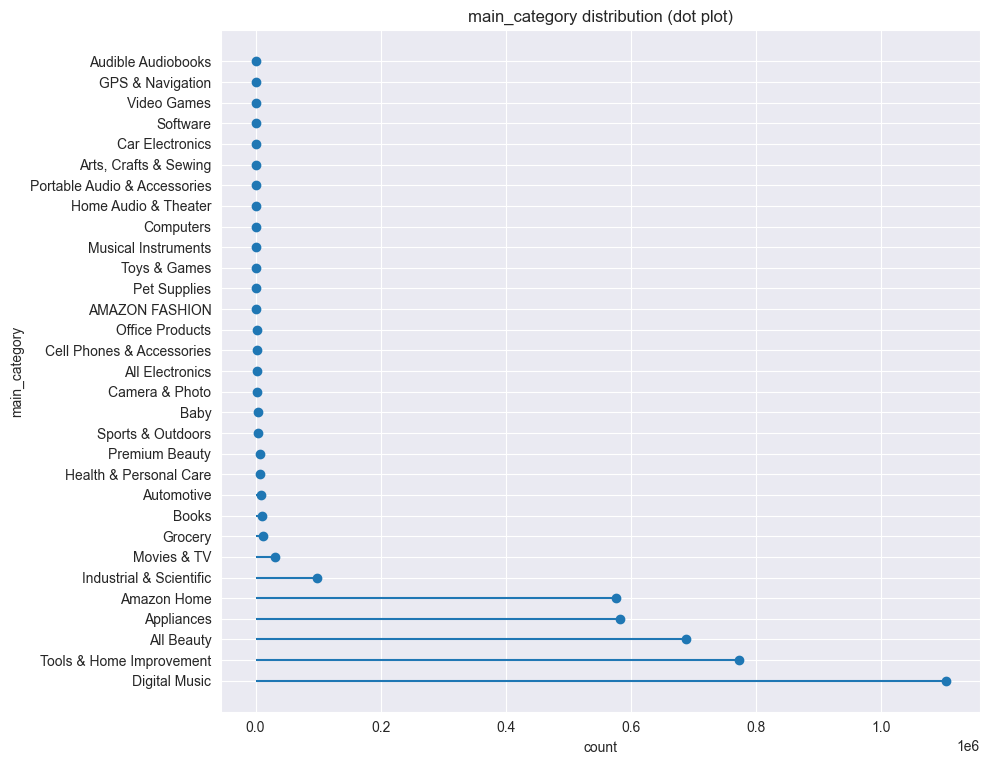

In [5]:
counts = merged_df["main_category"].value_counts().reset_index()
counts.columns = ["main_category", "count"]

plt.figure(figsize=(10, max(4, len(counts) * 0.25)))
plt.hlines(y=counts["main_category"], xmin=0, xmax=counts["count"])
plt.plot(counts["count"], counts["main_category"], "o")
plt.title("main_category distribution (dot plot)")
plt.xlabel("count")
plt.ylabel("main_category")
plt.tight_layout()
plt.show()


In [6]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

cat_cols = ["main_category", "store"]
num_cols = ["average_rating", "rating_number"]

# Keep only needed cols and drop rows with missing values in them
df = merged_df[cat_cols + num_cols].copy()
df = df.dropna(subset=cat_cols + num_cols)

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols),
    ],
    remainder="drop",
)


In [7]:
from sklearn.cluster import KMeans

k = 8  # try a few values: 6, 8, 10, 12
model = Pipeline(
    steps=[
        ("prep", preprocess),
        ("kmeans", KMeans(n_clusters=k, n_init="auto", random_state=42)),
    ]
)

labels = model.fit_predict(df)

df = df.assign(cluster=labels)

# If you want the cluster column back in merged_df for those rows:
merged_df = merged_df.copy()
merged_df.loc[df.index, "cluster"] = df["cluster"]
merged_df["cluster"] = merged_df["cluster"].astype("Int64")  # allows NA for unmatched rows

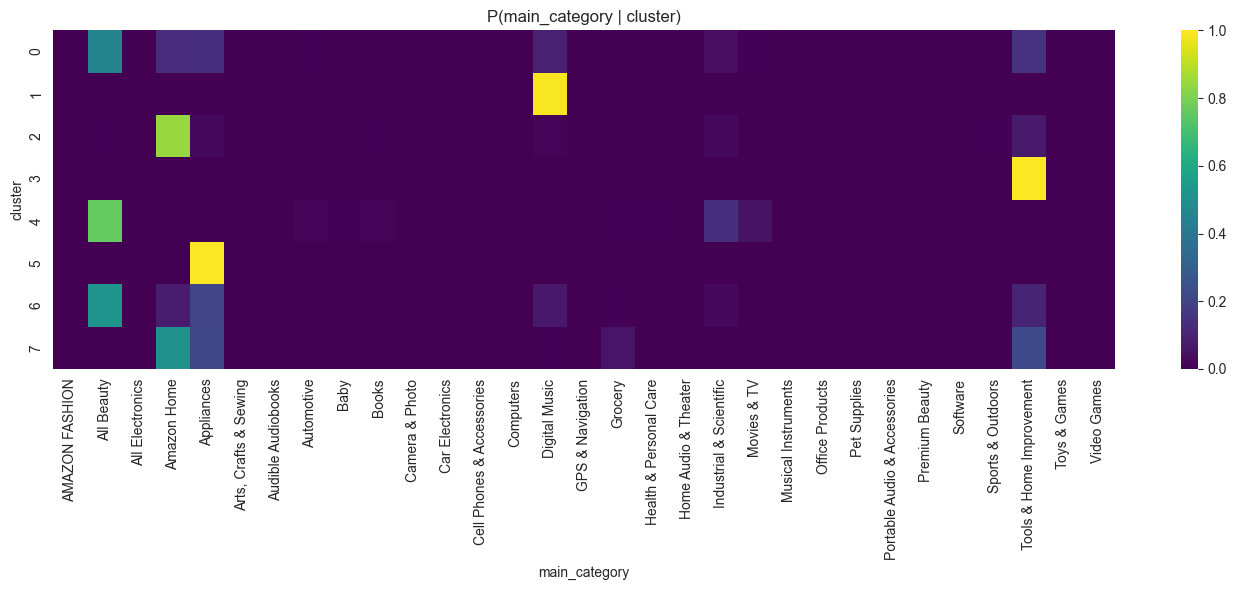

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

ct = pd.crosstab(df["cluster"], df["main_category"], normalize="index")

plt.figure(figsize=(14, 6))
sns.heatmap(ct, cmap="viridis")
plt.title("P(main_category | cluster)")
plt.xlabel("main_category")
plt.ylabel("cluster")
plt.tight_layout()
plt.show()


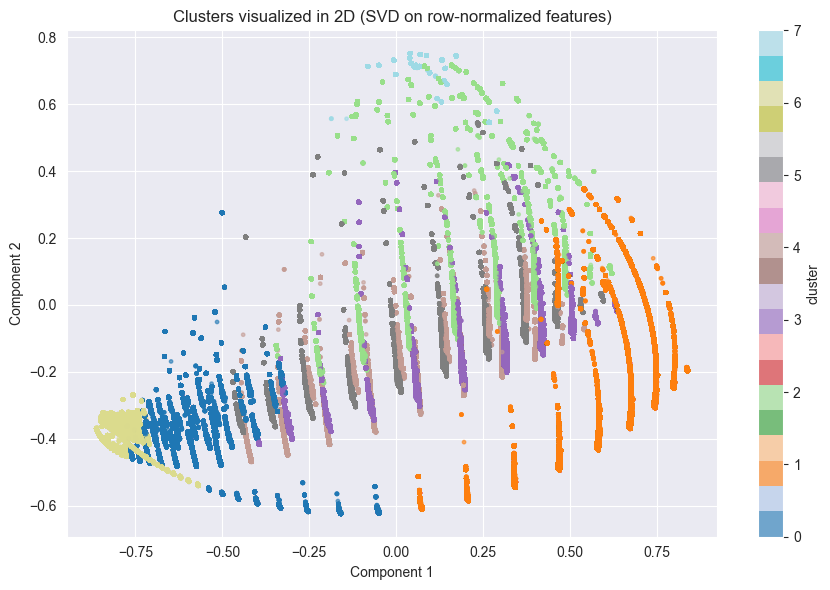

In [11]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
import numpy as np

# Transform features
X = model.named_steps["prep"].transform(df[cat_cols + num_cols])

# Normalize each row to unit length to reduce "cone/V-shape" artifacts common in sparse OHE spaces
Xn = Normalizer(copy=False).fit_transform(X)

svd = TruncatedSVD(n_components=2, random_state=42)
Z = svd.fit_transform(Xn)

plt.figure(figsize=(9, 6))
sc = plt.scatter(
    Z[:, 0], Z[:, 1],
    c=df["cluster"],
    s=6,
    alpha=0.6,
    cmap="tab20"
)
plt.title("Clusters visualized in 2D (SVD on row-normalized features)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(sc, label="cluster")
plt.tight_layout()
plt.show()

